<a href="https://colab.research.google.com/github/drosas1295/Ingen-IA/blob/main/03_Modelos_e_iteraciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

#bibliotecas de machine learning
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, ShuffleSplit

from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn import utils
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,KFold,GroupKFold
import lightgbm as lgb
import gc


import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"danielrosasmendoza","key":"d20966270cf2894cb8fe9a6f3e506cd9"}'}

In [ ]:
!pip install kaggle
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!kaggle competitions download -c playground-series-s3e6
!unzip playground-series-s3e6.zip

playground-series-s3e6.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  playground-series-s3e6.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## 1. Lectura del dataset

In [ ]:
train = pd.read_csv("train.csv")

In [ ]:
train

,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,0,34291,24,1,0,47,35693,2,1,2000,0,1,8,5196,369,0,3,3436795.2
1,1,95145,60,0,1,60,34773,1,4,2000,0,1,729,4496,277,0,6,9519958.0
2,2,92661,45,1,1,62,45457,4,8,2020,1,1,7473,8953,245,1,9,9276448.1
3,3,97184,99,0,0,59,15113,1,1,2000,0,1,6424,8522,256,1,9,9725732.2
4,4,61752,100,0,0,57,64245,8,4,2018,1,0,7151,2786,863,0,7,6181908.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22725,22725,55825,84,1,0,70,12031,3,10,2000,0,0,4477,786,345,0,0,5594137.1
22726,22726,65870,88,1,0,49,23197,9,9,2015,0,1,4811,2454,755,0,7,6594705.0
22727,22727,93192,42,1,0,39,8539,10,5,2014,1,0,5595,4072,789,0,0,9321511.4
22728,22728,65797,86,1,0,89,23197,2,10,2000,1,0,5358,2513,411,0,0,6584708.2


## 4. Preprocesado

#### 4.1 Simulación de datos faltantes

In [ ]:
train_mod = train.copy()

columnas = ['hasStormProtector','cityCode','made']

n_filas = len(train_mod)
n_faltantes1 = (13561)
n_faltantes2 = (2278)
n_faltantes3 = (1953)
indices_faltantes1 = np.random.choice(n_filas, n_faltantes1, replace=False)
indices_faltantes2 = np.random.choice(n_filas, n_faltantes2, replace=False)
indices_faltantes3 = np.random.choice(n_filas, n_faltantes3, replace=False)
train_mod.loc[indices_faltantes1,(columnas[0])] = np.nan
train_mod.loc[indices_faltantes2,(columnas[1])] = np.nan
train_mod.loc[indices_faltantes3,(columnas[2])] = np.nan

#### 4.2 Eliminación de datos anómalos

In [ ]:
anomalos = train_mod[train_mod['made'] == 10000].index.tolist()
train_mod = train_mod.drop(anomalos)

#### 4.3 Eliminación de variables con muchos datos faltantes

In [ ]:
train_mod = train_mod.drop(['hasStormProtector'], axis = 1)

#### 4.4 Relleno de datos faltantes

In [ ]:
train_mod['cityCode'].fillna(train_mod.cityCode.median(), inplace=True)
train_mod['made'].fillna(train_mod.made.median(), inplace=True)

## 5. Métodos supervisados

#### 5.1 Selección de Modelos

La métrica para medir el desempeño de los modelos es el RMSE (Root Mean Squared Error)

In [ ]:
#Función para calcular el RMSE de los modelos implementados
def RMSE(y_actual, y_pred):
    return np.sqrt(mean_squared_error(y_actual, y_pred))

In [ ]:
#Función para reportar el error del modelo
def report_cv_score(z):
    
    #RMSE en prueba y entrenamiento
    lr_ts_score = z['test_score']*(-1)
    lr_tr_score = z['train_score']*(-1)
    lin_rmse_ts = np.sqrt(lr_ts_score)
    lin_rmse_tr = np.sqrt(lr_tr_score)
    print("RMSE Test: ", "{:.5f}".format(np.mean(lin_rmse_ts)), "(±", "{:.8f}".format(np.std(lin_rmse_ts)),")")
    print("RMSE Train: ", "{:.5f}".format(np.mean(lin_rmse_tr)), "(±", "{:.8f}".format(np.std(lin_rmse_tr)),")")

In [ ]:
X = train_mod.drop(['price'],axis = 1)
y = train_mod['price'].values

A continuación eliminamos las variables con menos correlación según el análisis realizado en la exploracion de datos, es decir, aquellos cuyo valor absoluto de correlación sea menor a 0,01 (< 1%).

In [ ]:
X = X.drop(['isNewBuilt','hasPool','hasStorageRoom','hasYard','attic','id','numPrevOwners','hasGuestRoom','cityPartRange'],axis = 1)

In [ ]:
#Partición de los datos
from sklearn.model_selection import train_test_split

test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación

print (X.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

#Xtn, ytn son los datos que se usan para entrenar el modelo
#Xts, yts son los datos que se usan para probar el modelo
Xtn, Xts, ytn, yts = train_test_split(X, y, test_size=test_size)
print (Xtn.shape, Xts.shape)

(22726, 7) (22726,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(15908, 7) (6818, 7)


In [ ]:
estimator1 = LinearRegression()
estimator2 = DecisionTreeRegressor(max_depth=5)
estimator3 = RandomForestRegressor(n_estimators = 2,max_depth = 5)

In [ ]:
#Selección de modelos

zscores = []
estimators = [estimator1, estimator2, estimator3]
for estimator in estimators:
    print("---------")
    z = cross_validate(estimator, Xtn, ytn, return_train_score=True, return_estimator=False,
                       scoring="neg_mean_squared_error", cv=ShuffleSplit(n_splits=30, test_size=val_size))
    report_cv_score(z)
    zscores.append(np.mean(np.sqrt(z['test_score']*(-1))))
best = np.argmin(zscores)
print ("Seleccionado: ", best)
best_estimator = estimators[best]
print ("\n Mejor modelo: ")
print (best_estimator)

---------
RMSE Test:  4668776.74206 (± 2437569.30845924 )
RMSE Train:  1449844.37782 (± 1227810.47395095 )
---------
RMSE Test:  162264.77460 (± 22700.90429467 )
RMSE Train:  165686.88869 (± 16778.20598915 )
---------
RMSE Test:  155031.22055 (± 27380.22057033 )
RMSE Train:  159304.85364 (± 20296.82454090 )
Seleccionado:  2

 Mejor modelo: 
RandomForestRegressor(max_depth=5, n_estimators=2)


Despues de multiples ejecuciones, los modelos que dan mejor rendimiento corresponden a LinearRegression y RandomForest, por lo que se usarán estos dos para trabajar.

#### 5.2 Mejores hiperparámetros para RandomForest

Scikit-Learn permite analizar diferentes hiperparámetros para obtener la mejor selección de hiperparámetros de un modelo y que así sea más robusto. Además se le puede brindar un diccionario con diferentes valores para cada hiperparámetros y así hallar cual es la mejor opción.

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
#Esta celda toma un tiempo considerable en completarse
parametros = { 'n_estimators': [5,10,15],
              'max_depth':[5,7,9]}

forest_reg = GridSearchCV(estimator = estimator3,
                        param_grid = parametros,
                        cv = ShuffleSplit(n_splits= 5, test_size=val_size), 
                        scoring = 'neg_mean_squared_error',
                        verbose = 1,
                        return_train_score = True,
                        n_jobs = -1)
forest_reg.fit(Xtn, ytn)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.4285714285714286,
       train_size=None),
             estimator=RandomForestRegressor(max_depth=5, n_estimators=2),
             n_jobs=-1,
             param_grid={'max_depth': [5, 7, 9], 'n_estimators': [5, 10, 15]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [ ]:
print("Mejor estimador Random Forest: ",forest_reg.best_estimator_)
print("Mejores parámetros para el estimador Random Forest: ", forest_reg.best_params_)

Mejor estimador Random Forest:  RandomForestRegressor(max_depth=7, n_estimators=10)
Mejores parámetros para el estimador Random Forest:  {'max_depth': 7, 'n_estimators': 10}


In [ ]:
Rdm_forest = RandomForestRegressor(n_estimators = 10,max_depth = 7)
Rdm_forest.fit(Xtn, ytn)

RandomForestRegressor(max_depth=7, n_estimators=10)

In [ ]:
#Desempeño del modelo Random Forest seleccionado

print('RMSE del Random Forest en entrenamiento: ',"{:.5f}".format(RMSE((ytn) , (Rdm_forest.predict(Xtn)))))
print('RMSE del Random Forest seleccionado: ',"{:.5f}".format(RMSE(yts , Rdm_forest.predict(Xts))))

RMSE del Random Forest en entrenamiento:  129797.50493
RMSE del Random Forest seleccionado:  131788.07175


## 6. Métodos no supervisados

#### 6.1 PCA

In [ ]:
X = train_mod.drop(['price'],axis = 1)
y = train_mod['price'].values

In [ ]:
from sklearn.decomposition import PCA
components = [1,3,5,7,9]
test_size = 0.3
val_size  = test_size/(1-test_size)
perf = [] #desempeños de los modelos
Rdm_forest = RandomForestRegressor(n_estimators = 5,max_depth = 9)
for i in components:
    pca = PCA(n_components = i)
    X_t = pca.fit_transform(X)
    
    #Partición de datos
    Xtn, Xts, ytn, yts = train_test_split(X_t, y, test_size=test_size)
    print (Xtn.shape, Xts.shape)
    
    Rdm_forest.fit(Xtn, ytn)
    perf.append(RMSE(yts , Rdm_forest.predict(Xts)))
    print('RMSE del modelo con ', i ,'elementos: ',"{:.5f}".format(RMSE(yts , Rdm_forest.predict(Xts))))
    print('------------')

print('Mejor RMSE: ',"{:.5f}".format(np.min(perf)),'  ; obtenido con ',components[np.argmin(perf)],' componentes para PCA')
    

(15907, 1) (6818, 1)
RMSE del modelo con  1 elementos:  255068.03187
------------
(15907, 3) (6818, 3)
RMSE del modelo con  3 elementos:  223269.90403
------------
(15907, 5) (6818, 5)
RMSE del modelo con  5 elementos:  260455.97475
------------
(15907, 7) (6818, 7)
RMSE del modelo con  7 elementos:  216384.01806
------------
(15907, 9) (6818, 9)
RMSE del modelo con  9 elementos:  230288.58265
------------
Mejor RMSE:  216384.01806   ; obtenido con  7  componentes para PCA


In [ ]:
#MEJOR PCA
pca = PCA(n_components = 7)
X_t1 = pca.fit_transform(X)
Xtn, Xts, ytn, yts = train_test_split(X_t1, y, test_size=test_size)
print (Xtn.shape, Xts.shape)

(15907, 7) (6818, 7)


In [ ]:
#Nota: Correr esta celda toma un tiempo considerable
parametros = { 'n_estimators': [5,10,15],
              'max_depth':[5,7,9]}

forest_reg = GridSearchCV(estimator = estimator3,
                        param_grid = parametros,
                        cv = ShuffleSplit(n_splits= 5, test_size=val_size), 
                        scoring = 'neg_mean_squared_error',
                        verbose = 1,
                        return_train_score = True,
                        n_jobs = -1)
forest_reg.fit(Xtn, ytn)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.4285714285714286,
       train_size=None),
             estimator=RandomForestRegressor(max_depth=5, n_estimators=2),
             n_jobs=-1,
             param_grid={'max_depth': [5, 7, 9], 'n_estimators': [5, 10, 15]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [ ]:
print("Mejor estimador Random Forest: ",forest_reg.best_estimator_)
print("Mejores parámetros para el estimador Random Forest: ", forest_reg.best_params_)

Mejor estimador Random Forest:  RandomForestRegressor(max_depth=5, n_estimators=10)
Mejores parámetros para el estimador Random Forest:  {'max_depth': 5, 'n_estimators': 10}


In [ ]:
#Mejor random forest para el PCA obtenido
test_size = 0.3
val_size  = test_size/(1-test_size)
Xtn, Xts, ytn, yts = train_test_split(X_t1, y, test_size=test_size)
print (Xtn.shape, Xts.shape)
Rdm_forest = RandomForestRegressor(n_estimators = 10,max_depth = 5)
Rdm_forest.fit(Xtn, ytn)

(15907, 7) (6818, 7)


RandomForestRegressor(max_depth=5, n_estimators=10)

In [ ]:
#Desempeño del modelo Random Forest seleccionado

print('RMSE del Random Forest en entrenamiento: ',"{:.5f}".format(RMSE((ytn) , (Rdm_forest.predict(Xtn)))))
print('RMSE del Random Forest seleccionado: ',"{:.5f}".format(RMSE(yts , Rdm_forest.predict(Xts))))

RMSE del Random Forest en entrenamiento:  200142.19928
RMSE del Random Forest seleccionado:  197691.12181


## 7. Curvas de aprendizaje

#### 7.1 Métodos supervisados

In [ ]:
X = train_mod.drop(['price'],axis = 1)
y = train_mod['price'].values
X = X.drop(['isNewBuilt','hasPool','hasStorageRoom','hasYard','attic','id','numPrevOwners','hasGuestRoom','cityPartRange'],axis = 1)

In [ ]:
test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación


print (X.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

#Xtn, ytn son los datos que se usan para entrenar el modelo
#Xts, yts son los datos que se usan para probar el modelo
Xtn, Xts, ytn, yts = train_test_split(X, y, test_size=test_size)
print (Xtn.shape, Xts.shape)

(22725, 7) (22725,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(15907, 7) (6818, 7)


##### 7.1.1 Linear Regression

In [ ]:
def lc_plot(estimator,X,y):
    train_sizes, train_scores, valid_scores = learning_curve(estimator, X, y, train_sizes= [0.3, 0.5,0.7,0.9], 
                 scoring = 'neg_root_mean_squared_error', cv = ShuffleSplit(n_splits=10, test_size=val_size))
    
    train_scores = np.abs(train_scores)
    valid_scores = np.abs(valid_scores)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)

    plt.subplots(1, figsize=(5,5))
    plt.plot(train_sizes, train_mean, '--', color="r",  label="Training score")
    plt.plot(train_sizes, valid_mean, color="g", label="Cross-validation score")



    plt.grid()
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("RMSE"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
    return plt

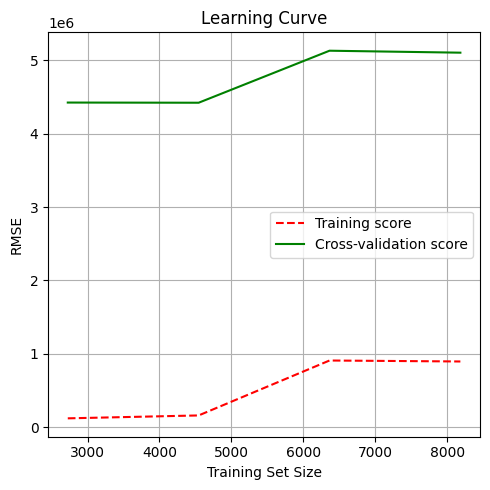

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

In [ ]:
lc_plot(estimator1,Xtn,ytn)

##### 7.1.2 Random Forest

In [ ]:
Rdm_forest = RandomForestRegressor(n_estimators = 10,max_depth = 7)

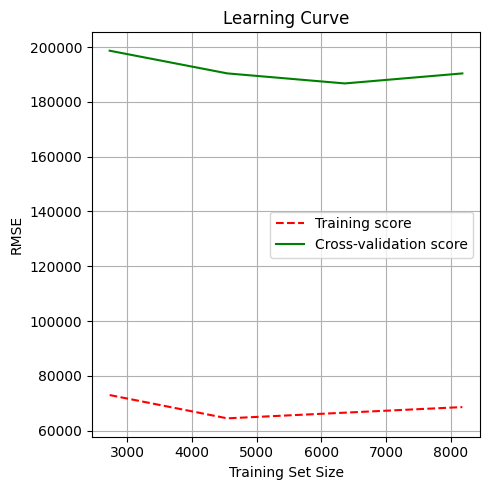

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

In [ ]:
lc_plot(Rdm_forest,Xtn,ytn)

#### 7.2 Métodos no supervisados + supervisados

##### 7.2.1 PCA + RandomForest

In [ ]:
X = train_mod.drop(['price'],axis = 1)
y = train_mod['price'].values

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 7)
X_t1 = pca.fit_transform(X)
test_size = 0.3
val_size  = test_size/(1-test_size)
Xtn, Xts, ytn, yts = train_test_split(X_t1, y, test_size=test_size)
Rdm_forest = RandomForestRegressor(n_estimators = 10,max_depth = 7)

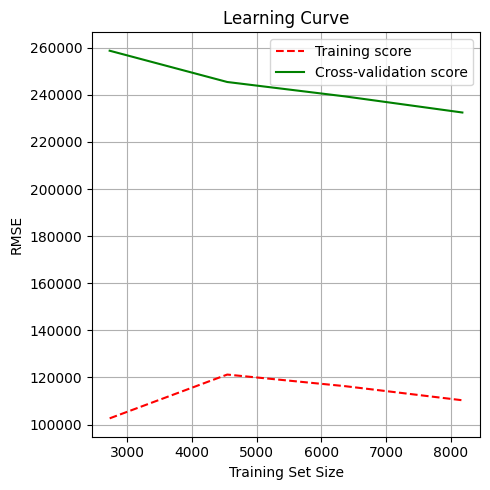

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

In [ ]:
lc_plot(Rdm_forest,Xtn,ytn)